In [1]:
# Install Kaggle API
!pip install -q kaggle

In [2]:
# Upload your kaggle.json file
from google.colab import files
files.upload() # Uploaded the file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"najeebahmadbhuiyan","key":"42ff0056133e89657927143231fe1ee6"}'}

In [3]:
# Set permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
# Download dataset
!kaggle datasets download -d mbkinaci/fruit-images-for-object-detection

Dataset URL: https://www.kaggle.com/datasets/mbkinaci/fruit-images-for-object-detection
License(s): CC0-1.0
  0% 0.00/28.4M [00:00<?, ?B/s]
100% 28.4M/28.4M [00:00<00:00, 1.39GB/s]


In [5]:
# Unzip main archive
!unzip -q fruit-images-for-object-detection.zip -d fruit_data

## 1. Installing Dependencies & Quick Env check

In [7]:
!pip install -q xmltodict torch torchvision onnx onnxruntime scikit-learn seaborn matplotlib pillow pandas tqdm opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 115.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [8]:
import sys, torch, onnxruntime, xmltodict
print("Python:", sys.version.splitlines()[0])
print("Torch:", torch.__version__, " CUDA available:", torch.cuda.is_available())
print("ONNX Runtime:", onnxruntime.__version__)
print("xmltodict OK")

Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
Torch: 2.6.0+cu124  CUDA available: True
ONNX Runtime: 1.22.1
xmltodict OK


## 2. Dataset Checking

In [9]:
from pathlib import Path
TRAIN_DIR = Path("/content/fruit_data/train_zip/train")
VAL_DIR   = Path("/content/fruit_data/test_zip/test")
print("Train dir exists?", TRAIN_DIR.exists())
print("Val dir exists?  ", VAL_DIR.exists())
if TRAIN_DIR.exists():
    print("Train samples (jpg/xml):", list(TRAIN_DIR.glob("*.jpg"))[:5], list(TRAIN_DIR.glob("*.xml"))[:5])
if VAL_DIR.exists():
    print("Val samples (jpg/xml):", list(VAL_DIR.glob("*.jpg"))[:5], list(VAL_DIR.glob("*.xml"))[:5])


Train dir exists? True
Val dir exists?   True
Train samples (jpg/xml): [PosixPath('/content/fruit_data/train_zip/train/banana_42.jpg'), PosixPath('/content/fruit_data/train_zip/train/orange_56.jpg'), PosixPath('/content/fruit_data/train_zip/train/apple_1.jpg'), PosixPath('/content/fruit_data/train_zip/train/orange_11.jpg'), PosixPath('/content/fruit_data/train_zip/train/apple_19.jpg')] [PosixPath('/content/fruit_data/train_zip/train/orange_34.xml'), PosixPath('/content/fruit_data/train_zip/train/apple_22.xml'), PosixPath('/content/fruit_data/train_zip/train/mixed_18.xml'), PosixPath('/content/fruit_data/train_zip/train/apple_50.xml'), PosixPath('/content/fruit_data/train_zip/train/orange_72.xml')]
Val samples (jpg/xml): [PosixPath('/content/fruit_data/test_zip/test/apple_81.jpg'), PosixPath('/content/fruit_data/test_zip/test/apple_94.jpg'), PosixPath('/content/fruit_data/test_zip/test/orange_85.jpg'), PosixPath('/content/fruit_data/test_zip/test/apple_78.jpg'), PosixPath('/content/frui

## 3. Imports, XML parser, item builder

In [10]:
import os, glob, random, time, json
from pathlib import Path
import xmltodict
from PIL import Image, ImageOps
import numpy as np
import pandas as pd
from tqdm import tqdm

# torch imports are needed later too
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as T

def parse_voc_xml(xml_path: str):
    """Return list of objects for a VOC xml file; [] if missing/invalid."""
    try:
        with open(xml_path, 'r', encoding='utf-8') as f:
            ann = xmltodict.parse(f.read())['annotation']
    except Exception:
        return []
    img_path = xml_path.replace('.xml', '.jpg')
    if not os.path.exists(img_path):
        img_path = xml_path.replace('.xml', '.jpeg')
    if not os.path.exists(img_path):
        img_path = xml_path.replace('.xml', '.png')
    if not os.path.exists(img_path):
        return []
    objs = ann.get('object', [])
    if objs is None:
        return []
    if isinstance(objs, dict):
        objs = [objs]
    try:
        iw = int(ann['size']['width']); ih = int(ann['size']['height'])
    except Exception:
        with Image.open(img_path) as im:
            iw, ih = im.size
    out = []
    for o in objs:
        name = o['name']
        box = o['bndbox']
        xmin = int(box['xmin']); ymin = int(box['ymin']); xmax = int(box['xmax']); ymax = int(box['ymax'])
        xmin = max(0, min(iw-1, xmin)); xmax = max(0, min(iw-1, xmax))
        ymin = max(0, min(ih-1, ymin)); ymax = max(0, min(ih-1, ymax))
        if xmax <= xmin or ymax <= ymin:
            continue
        out.append({'name': name, 'xmin': xmin, 'ymin': ymin, 'xmax': xmax, 'ymax': ymax,
                    'img_path': img_path, 'img_w': iw, 'img_h': ih})
    return out

def build_items_from_folder(folder: str):
    xmls = sorted(glob.glob(os.path.join(folder, '*.xml')))
    items = []
    for x in xmls:
        parsed = parse_voc_xml(x)
        if not parsed:
            continue
        # pick the largest bbox (assume single target of interest)
        best = max(parsed, key=lambda o: (o['xmax']-o['xmin']) * (o['ymax']-o['ymin']))
        items.append(best)
    return items


## 4. EdgeDepth model (MicroTinyDetector)

In [11]:
class MicroTinyDetector(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 12, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(12, 16, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Sequential(nn.Flatten(), nn.Linear(16, 32), nn.ReLU())
        self.bbox_head = nn.Sequential(nn.Linear(32, 16), nn.ReLU(), nn.Linear(16, 4), nn.Sigmoid())
        self.cls_head  = nn.Sequential(nn.Linear(32, 16), nn.ReLU(), nn.Linear(16, num_classes))

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        bbox = self.bbox_head(x)
        logits = self.cls_head(x)
        return bbox, logits

# quick sanity
print("MicroTinyDetector params:", sum(p.numel() for p in MicroTinyDetector(num_classes=3).parameters()))


MicroTinyDetector params: 4563


## 5. Augmentations + Dataset class (scale augmentation included)

In [12]:
import random
from typing import List, Dict

def apply_random_flip(image: Image.Image, box: Dict, p=0.5):
    if random.random() < p:
        image = ImageOps.mirror(image)
        iw = image.width
        xmin, xmax = box['xmin'], box['xmax']
        box['xmin'] = iw - 1 - xmax
        box['xmax'] = iw - 1 - xmin
    return image, box

def apply_random_scale_keep_canvas(image: Image.Image, box: Dict, scale_min=0.5, scale_max=1.8):
    iw, ih = image.size
    s = random.uniform(scale_min, scale_max)
    new_w = max(1, int(round(iw * s)))
    new_h = max(1, int(round(ih * s)))
    img_resized = image.resize((new_w, new_h), Image.BILINEAR)
    xmin = int(round(box['xmin'] * (new_w / iw)))
    xmax = int(round(box['xmax'] * (new_w / iw)))
    ymin = int(round(box['ymin'] * (new_h / ih)))
    ymax = int(round(box['ymax'] * (new_h / ih)))
    if new_w >= iw and new_h >= ih:
        left = (new_w - iw) // 2
        top  = (new_h - ih) // 2
        img_cropped = img_resized.crop((left, top, left + iw, top + ih))
        xmin = xmin - left; xmax = xmax - left
        ymin = ymin - top;  ymax = ymax - top
        out_img = img_cropped
    else:
        canvas = Image.new('RGB', (iw, ih), (0,0,0))
        left = (iw - new_w) // 2
        top  = (ih - new_h) // 2
        canvas.paste(img_resized, (left, top))
        xmin = xmin + left; xmax = xmax + left
        ymin = ymin + top;  ymax = ymax + top
        out_img = canvas
    xmin = max(0, min(iw-1, xmin)); xmax = max(0, min(iw-1, xmax))
    ymin = max(0, min(ih-1, ymin)); ymax = max(0, min(ih-1, ymax))
    box['xmin'], box['xmax'], box['ymin'], box['ymax'] = xmin, xmax, ymin, ymax
    return out_img, box

class EdgeDepthDataset(Dataset):
    def __init__(self, items, classes: List[str], img_size=64, augment=False, scale_min=0.5, scale_max=1.8):
        self.items = items
        self.classes = classes
        self.class2idx = {c:i for i,c in enumerate(classes)}
        self.img_size = img_size
        self.augment = augment
        self.scale_min = scale_min
        self.scale_max = scale_max
        self.color_jitter = T.ColorJitter(brightness=0.12, contrast=0.12, saturation=0.12, hue=0.02)
        self.to_tensor = T.ToTensor()
        self.resize_final = T.Resize((img_size, img_size))

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        it = self.items[idx]
        img = Image.open(it['img_path']).convert('RGB')
        box = dict(xmin=it['xmin'], ymin=it['ymin'], xmax=it['xmax'], ymax=it['ymax'])
        orig_w, orig_h = img.size

        if self.augment:
            img, box = apply_random_flip(img, box, p=0.5)
            img, box = apply_random_scale_keep_canvas(img, box, scale_min=self.scale_min, scale_max=self.scale_max)

        cx = (box['xmin'] + box['xmax']) / 2.0
        cy = (box['ymin'] + box['ymax']) / 2.0
        bw = box['xmax'] - box['xmin']
        bh = box['ymax'] - box['ymin']
        bw = max(1.0, bw); bh = max(1.0, bh)
        reg = np.array([cx / orig_w, cy / orig_h, bw / orig_w, bh / orig_h], dtype=np.float32)

        img = self.color_jitter(img) if self.augment else img
        img = self.resize_final(img)
        img_t = self.to_tensor(img)
        cls_idx = self.class2idx.get(it['name'], 0)
        return img_t, torch.from_numpy(reg), torch.tensor(cls_idx, dtype=torch.long)


## 6. GIoU loss, evaluate & evaluate_all

In [13]:
def bbox_cxcywh_to_xyxy(box):
    cx, cy, w, h = box[...,0], box[...,1], box[...,2], box[...,3]
    x1 = cx - 0.5*w; y1 = cy - 0.5*h
    x2 = cx + 0.5*w; y2 = cy + 0.5*h
    return x1, y1, x2, y2

def giou_loss(pred, target, eps=1e-7):
    x11, y11, x12, y12 = bbox_cxcywh_to_xyxy(pred)
    x21, y21, x22, y22 = bbox_cxcywh_to_xyxy(target)
    xi1 = torch.max(x11, x21); yi1 = torch.max(y11, y21)
    xi2 = torch.min(x12, x22); yi2 = torch.min(y12, y22)
    iw = (xi2 - xi1).clamp(min=0); ih = (yi2 - yi1).clamp(min=0)
    inter = iw * ih
    area1 = (x12 - x11).clamp(min=0) * (y12 - y11).clamp(min=0)
    area2 = (x22 - x21).clamp(min=0) * (y22 - y21).clamp(min=0)
    union = area1 + area2 - inter + eps
    iou = inter / union
    cx1 = torch.min(x11, x21); cy1 = torch.min(y11, y21)
    cx2 = torch.max(x12, x22); cy2 = torch.max(y12, y22)
    c_w = (cx2 - cx1).clamp(min=0); c_h = (cy2 - cy1).clamp(min=0)
    c_area = c_w * c_h + eps
    giou = iou - (c_area - union) / c_area
    return 1.0 - giou

def evaluate(model, dataloader, device):
    model.eval()
    total = 0; correct = 0; ious = []
    with torch.no_grad():
        for imgs, regs, cls in dataloader:
            imgs = imgs.to(device); regs = regs.to(device); cls = cls.to(device)
            pred_regs, pred_logits = model(imgs)
            preds = pred_logits.argmax(dim=1)
            correct += (preds == cls).sum().item()
            total += imgs.size(0)
            giou = 1.0 - giou_loss(pred_regs, regs)
            ious.append(giou.cpu().numpy())
    mean_iou = float(np.concatenate(ious).mean()) if ious else 0.0
    acc = correct / total if total>0 else 0.0
    return mean_iou, acc

def evaluate_all(model, dataloader, device, classes):
    model.eval()
    gts = []; preds = []; confs = []; probs_all = []; gt_regs = []; pred_regs = []; ious = []
    with torch.no_grad():
        for imgs, regs, cls in tqdm(dataloader, desc="Eval all"):
            imgs = imgs.to(device); regs = regs.to(device); cls = cls.to(device)
            bbox_pred, logits = model(imgs)
            probs = F.softmax(logits, dim=1).cpu().numpy()
            preds_idx = logits.argmax(dim=1).cpu().numpy()
            confs_batch = probs.max(axis=1)
            giou_vals = (1.0 - giou_loss(bbox_pred, regs)).cpu().numpy()
            for i in range(imgs.size(0)):
                gts.append(int(cls[i].cpu().item()))
                preds.append(int(preds_idx[i]))
                confs.append(float(confs_batch[i]))
                probs_all.append(probs[i])
                gt_regs.append(regs[i].cpu().numpy())
                pred_regs.append(bbox_pred[i].cpu().numpy())
                ious.append(float(giou_vals[i].item()) if hasattr(giou_vals[i],'item') else float(giou_vals[i]))
    import numpy as _np
    return {
        'gt': _np.array(gts, dtype=int),
        'pred': _np.array(preds, dtype=int),
        'conf': _np.array(confs, dtype=float),
        'probs': _np.array(probs_all, dtype=float),
        'gt_regs': _np.stack(gt_regs),
        'pred_regs': _np.stack(pred_regs),
        'iou': _np.array(ious, dtype=float),
        'classes': classes
    }


## 7.Training Function (With history)

In [14]:
from collections import defaultdict
def train_with_history(model, train_loader, val_loader, device, epochs=30, lr=1e-3, bbox_weight=3.0, save_path='micro_best_edgedepth.pth'):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=4, verbose=True)
    bbox_loss_fn = nn.SmoothL1Loss()
    best_val = -1.0
    history = defaultdict(list)
    for epoch in range(1, epochs+1):
        model.train()
        running = 0.0
        t0 = time.time()
        for imgs, regs, cls in train_loader:
            imgs = imgs.to(device); regs = regs.to(device); cls = cls.to(device)
            opt.zero_grad()
            pred_regs, pred_logits = model(imgs)
            loss_reg1 = bbox_loss_fn(pred_regs, regs)
            loss_reg2 = giou_loss(pred_regs, regs).mean()
            loss_cls = nn.CrossEntropyLoss()(pred_logits, cls)
            loss = bbox_weight * (loss_reg1 + 0.5 * loss_reg2) + loss_cls
            loss.backward(); opt.step()
            running += loss.item() * imgs.size(0)
        tr_loss = running / len(train_loader.dataset)
        val_iou, val_acc = evaluate(model, val_loader, device)
        scheduler.step(tr_loss)
        t1 = time.time()
        print(f"Epoch {epoch:02d}  train_loss={tr_loss:.4f}  val_iou={val_iou:.4f}  val_acc={val_acc:.3f}  time={(t1-t0):.1f}s")
        history['train_loss'].append(float(tr_loss))
        history['val_iou'].append(float(val_iou))
        history['val_acc'].append(float(val_acc))
        if val_iou > best_val:
            best_val = val_iou
            torch.save(model.state_dict(), save_path)
            print("  saved best")
    try:
        with open('training_history.json','w') as f:
            json.dump(history, f, indent=2)
    except Exception:
        pass
    print("Training finished. Best val_iou:", best_val)
    return history


## 8. Plotting and visualization helpers

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, average_precision_score, precision_recall_curve
import cv2

def plot_training_history(history, out_prefix="train_history"):
    plt.figure(figsize=(11,4))
    plt.subplot(1,2,1)
    plt.plot(history['train_loss'], label='train_loss')
    plt.xlabel('epoch'); plt.ylabel('loss'); plt.title('Training loss'); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history['val_iou'], label='val_iou'); plt.plot(history['val_acc'], label='val_acc')
    plt.xlabel('epoch'); plt.title('Val IoU & Acc'); plt.legend()
    plt.tight_layout()
    plt.savefig(f"{out_prefix}_curves.png", dpi=150)
    plt.show()

def plot_confusion(gt, pred, classes, out_path="confusion.png"):
    cm = confusion_matrix(gt, pred, labels=list(range(len(classes))))
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
    plt.tight_layout(); plt.savefig(out_path, dpi=150); plt.show()

def plot_pr_curves(gt, probs, classes, out_path="pr_curves.png"):
    plt.figure(figsize=(8,6))
    ap_per_class = {}
    for c in range(len(classes)):
        y_true = (gt == c).astype(int)
        y_score = probs[:, c]
        if y_true.sum() == 0:
            ap_per_class[classes[c]] = None
            continue
        ap = average_precision_score(y_true, y_score)
        ap_per_class[classes[c]] = float(ap)
        precision, recall, _ = precision_recall_curve(y_true, y_score)
        plt.plot(recall, precision, label=f"{classes[c]} (AP={ap:.3f})")
    plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall curves')
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.savefig(out_path, dpi=150); plt.show()
    return ap_per_class

def plot_iou_hist(iou_arr, out_path="iou_hist.png"):
    plt.figure(figsize=(6,4))
    plt.hist(iou_arr, bins=20)
    plt.xlabel('IoU'); plt.title('IoU distribution on validation set')
    plt.tight_layout(); plt.savefig(out_path, dpi=150); plt.show()

def norm_to_pixels(box_norm, img_w, img_h):
    cx, cy, w, h = box_norm
    cx_p = cx * img_w; cy_p = cy * img_h
    w_p = w * img_w; h_p = h * img_h
    xmin = int(round(cx_p - w_p/2)); ymin = int(round(cy_p - h_p/2))
    xmax = int(round(cx_p + w_p/2)); ymax = int(round(cy_p + h_p/2))
    xmin = max(0, xmin); ymin = max(0, ymin)
    xmax = min(img_w-1, xmax); ymax = min(img_h-1, ymax)
    return xmin, ymin, xmax, ymax

def save_result_images(model, val_ds, val_items, device, classes, out_dir="results", max_save=200):
    os.makedirs(out_dir, exist_ok=True)
    model.eval()
    saved = 0
    for idx in range(len(val_ds)):
        img_t, reg_true, cls_true = val_ds[idx]
        img_path = val_items[idx]['img_path']
        img_cv = cv2.imread(img_path)
        if img_cv is None:
            continue
        h, w = img_cv.shape[:2]
        inp = img_t.unsqueeze(0).to(device)
        with torch.no_grad():
            pred_reg, pred_logits = model(inp)
        pred_reg = pred_reg[0].cpu().numpy()
        pred_cls_idx = int(pred_logits.argmax(dim=1).cpu().item())
        gt_reg = reg_true.numpy()
        xmin_t, ymin_t, xmax_t, ymax_t = norm_to_pixels(gt_reg, w, h)
        xmin_p, ymin_p, xmax_p, ymax_p = norm_to_pixels(pred_reg, w, h)
        cv2.rectangle(img_cv, (xmin_t, ymin_t), (xmax_t, ymax_t), (0,255,0), 2)
        cv2.rectangle(img_cv, (xmin_p, ymin_p), (xmax_p, ymax_p), (0,0,255), 2)
        label = f"GT:{classes[int(cls_true)]}  PR:{classes[pred_cls_idx]}"
        cv2.putText(img_cv, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 1)
        out_path = Path(out_dir) / f"vis_{idx}_{Path(img_path).name}"
        cv2.imwrite(str(out_path), img_cv)
        saved += 1
        if saved >= max_save:
            break
    print(f"Saved {saved} result images to {out_dir}")


## 9. Build loaders, train, evaluate, save visuals

Train items: 207 Val items: 56
Using device: cuda
Weighted sampler enabled (oversample small bboxes).
Model params: 4563
No pretrained loaded (or invalid path).


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 01  train_loss=2.2860  val_iou=0.3238  val_acc=0.357  time=7.3s
  saved best
Epoch 02  train_loss=2.2709  val_iou=0.3352  val_acc=0.357  time=5.6s
  saved best
Epoch 03  train_loss=2.3055  val_iou=0.3448  val_acc=0.357  time=6.1s
  saved best
Epoch 04  train_loss=2.2063  val_iou=0.3583  val_acc=0.357  time=5.9s
  saved best
Epoch 05  train_loss=2.2414  val_iou=0.3714  val_acc=0.429  time=6.6s
  saved best
Epoch 06  train_loss=2.2119  val_iou=0.3927  val_acc=0.357  time=6.2s
  saved best
Epoch 07  train_loss=2.2075  val_iou=0.4245  val_acc=0.375  time=6.5s
  saved best
Epoch 08  train_loss=2.1426  val_iou=0.4608  val_acc=0.429  time=5.4s
  saved best
Epoch 09  train_loss=2.1567  val_iou=0.4765  val_acc=0.321  time=5.4s
  saved best
Epoch 10  train_loss=2.0623  val_iou=0.4825  val_acc=0.321  time=4.8s
  saved best
Epoch 11  train_loss=2.1305  val_iou=0.4803  val_acc=0.321  time=5.1s
Epoch 12  train_loss=2.1033  val_iou=0.4774  val_acc=0.375  time=6.0s
Epoch 13  train_loss=2.0880  v

Eval all: 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]


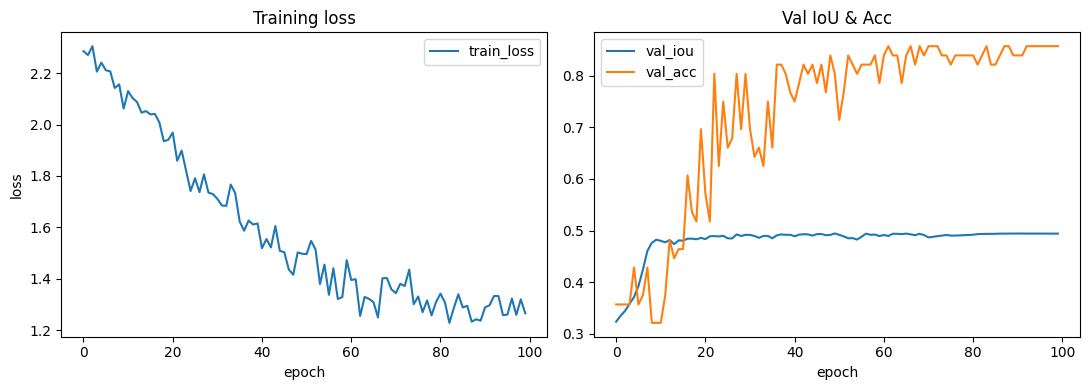

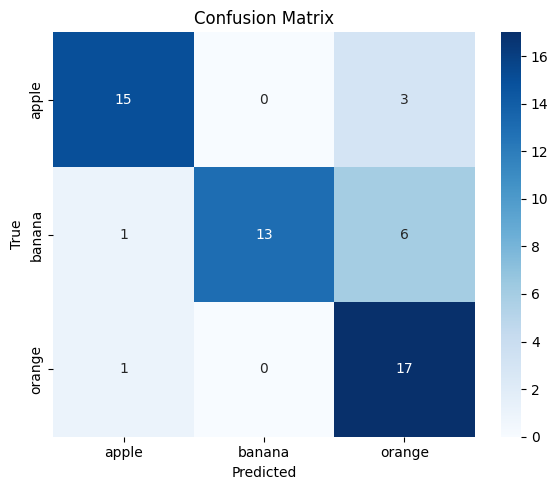


Classification report:

              precision    recall  f1-score   support

       apple     0.8824    0.8333    0.8571        18
      banana     1.0000    0.6500    0.7879        20
      orange     0.6538    0.9444    0.7727        18

    accuracy                         0.8036        56
   macro avg     0.8454    0.8093    0.8059        56
weighted avg     0.8509    0.8036    0.8053        56



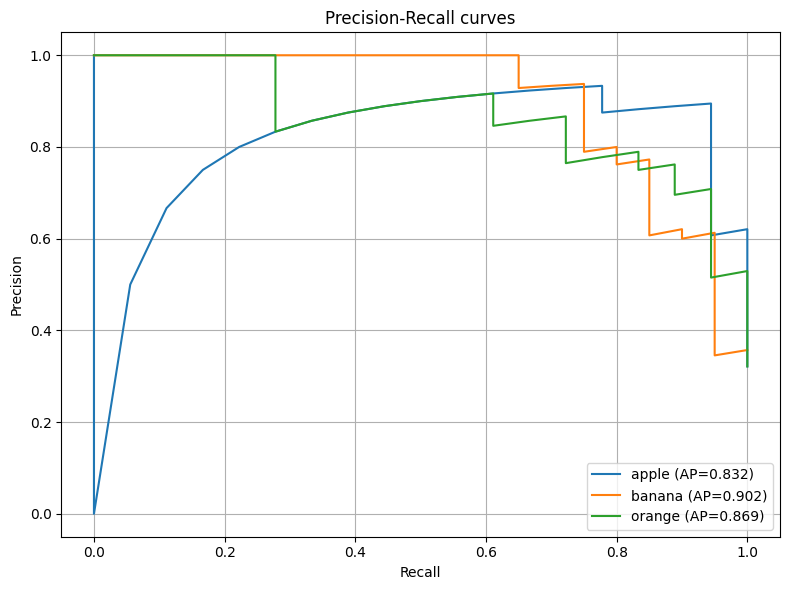

AP per class: {'apple': 0.8315799630063357, 'banana': 0.9017148172091165, 'orange': 0.8687500093072849}


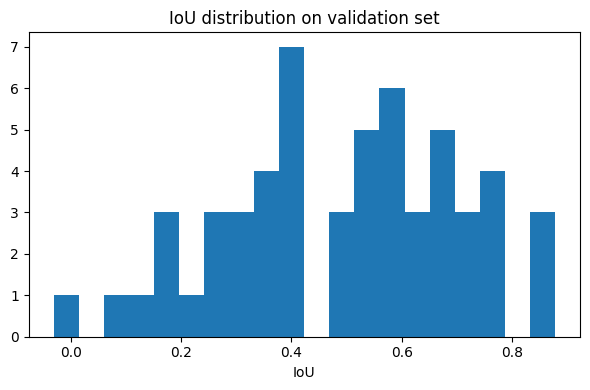

Mean IoU: 0.49456782319716047
Saved val_results_summary.csv (first few rows):
  gt_class pred_class  confidence       iou
0    apple      apple    0.925862  0.162725
1    apple      apple    0.958320  0.735720
2    apple      apple    0.933741  0.657828
3    apple      apple    0.977928  0.784145
4    apple      apple    0.922483  0.765699
Saved 56 result images to results


In [16]:
TRAIN_DIR = "/content/fruit_data/train_zip/train"
VAL_DIR   = "/content/fruit_data/test_zip/test"
CLASSES = ["apple","banana","orange"]
IMG_SIZE = 64
BATCH = 32
EPOCHS = 100
LR = 1e-3
BBOX_WEIGHT = 3.0
OVERSAMPLE_SMALL = True
PRETRAINED_PATH = "/content/micro_best_tiny_detector.pth"  # set None if not using
SAVE_RESULTS = True
MAX_SAVE = 200
EXPORT_ONNX = True

# Build items & datasets
train_items = build_items_from_folder(TRAIN_DIR)
val_items   = build_items_from_folder(VAL_DIR)
print("Train items:", len(train_items), "Val items:", len(val_items))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

train_ds = EdgeDepthDataset(train_items, CLASSES, img_size=IMG_SIZE, augment=True, scale_min=0.5, scale_max=1.8)
val_ds   = EdgeDepthDataset(val_items,   CLASSES, img_size=IMG_SIZE, augment=False)

sampler = None
if OVERSAMPLE_SMALL:
    areas = np.array([max(1,(it['xmax']-it['xmin']))*max(1,(it['ymax']-it['ymin'])) for it in train_items], dtype=np.float32)
    inv = 1.0 / (areas + 1e-6)
    weights = inv / inv.sum()
    sampler = WeightedRandomSampler(weights=weights.tolist(), num_samples=len(weights), replacement=True)
    print("Weighted sampler enabled (oversample small bboxes).")

if sampler is not None:
    train_loader = DataLoader(train_ds, batch_size=BATCH, sampler=sampler, num_workers=2, pin_memory=True)
else:
    train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

model = MicroTinyDetector(num_classes=len(CLASSES)).to(device)
print("Model params:", sum(p.numel() for p in model.parameters()))

# optionally load pretrained
if PRETRAINED_PATH and Path(PRETRAINED_PATH).exists():
    print("Loading pretrained:", PRETRAINED_PATH)
    model.load_state_dict(torch.load(PRETRAINED_PATH, map_location=device))
else:
    print("No pretrained loaded (or invalid path).")

# Train
history = train_with_history(model, train_loader, val_loader, device, epochs=EPOCHS, lr=LR, bbox_weight=BBOX_WEIGHT, save_path="micro_best_edgedepth.pth")

# Load best
best_pth = "micro_best_edgedepth.pth"
if Path(best_pth).exists():
    model.load_state_dict(torch.load(best_pth, map_location=device))
    print("Loaded best model:", best_pth)
else:
    print("Best model not found; using current model.")

# Export ONNX
if EXPORT_ONNX:
    try:
        onnx_path = "micro_edgedepth.onnx"
        model.eval()
        dummy = torch.randn(1, 3, IMG_SIZE, IMG_SIZE, device=device)
        torch.onnx.export(model, dummy, onnx_path, input_names=["input"], output_names=["bbox","logits"], opset_version=11)
        print("Exported ONNX:", onnx_path, "size:", Path(onnx_path).stat().st_size)
    except Exception as e:
        print("ONNX export failed:", e)

# Full evaluation & visuals
results = evaluate_all(model, val_loader, device, CLASSES)
gt = results['gt']; pred = results['pred']; probs = results['probs']; iou = results['iou']

# Plots & metrics
plot_training_history(history, out_prefix="train_history")
plot_confusion(gt, pred, CLASSES, out_path="confusion.png")
print("\nClassification report:\n")
print(classification_report(gt, pred, target_names=CLASSES, digits=4))
ap_per_class = plot_pr_curves(gt, probs, CLASSES, out_path="pr_curves.png")
print("AP per class:", ap_per_class)
plot_iou_hist(iou, out_path="iou_hist.png")
print("Mean IoU:", float(iou.mean()))
df = pd.DataFrame({'gt_class':[CLASSES[i] for i in gt], 'pred_class':[CLASSES[i] for i in pred], 'confidence':results['conf'], 'iou':results['iou']})
df.to_csv("val_results_summary.csv", index=False)
print("Saved val_results_summary.csv (first few rows):")
print(df.head())

# save images showing GT (green) and Pred (red)
if SAVE_RESULTS:
    save_result_images(model, val_ds, val_items, device, CLASSES, out_dir="results", max_save=MAX_SAVE)


Running enhanced synthetic test on: /content/fruit_data/test_zip/test/apple_77.jpg
Saved synthetic results to synthetic_scale_results.csv


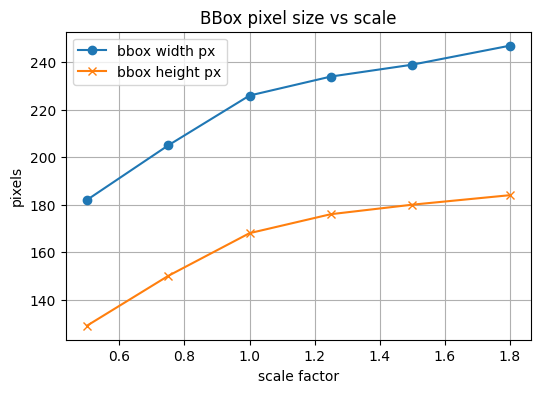

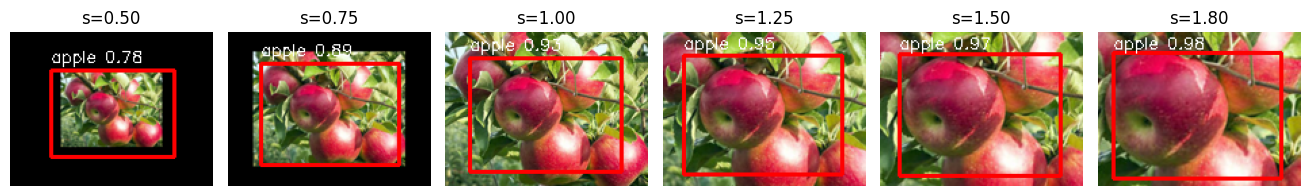

,scale,cx,cy,w_rel,h_rel,w_px,h_px,class,conf
0,0.50,0.506388,0.530248,0.607164,0.562698,182,129,apple,0.779054
1,0.75,0.501324,0.533869,0.683715,0.654025,205,150,apple,0.885875
2,1.00,0.495086,0.537347,0.751822,0.733863,226,168,apple,0.925862
3,1.25,0.492652,0.539132,0.781389,0.766761,234,176,apple,0.954287
4,1.50,0.492076,0.540583,0.797695,0.784081,239,180,apple,0.968753
5,1.80,0.489040,0.543145,0.823386,0.805578,247,184,apple,0.982438


In [18]:
# Enhanced synthetic-scale test - Colab cell
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torchvision.transforms as T
import pandas as pd
import os
from IPython.display import display

def synthetic_scale_test_visual(image_path, model_obj, device, img_size=64, scale_factors=None, classes=None, out_csv="synthetic_scale_results.csv"):
    if scale_factors is None:
        scale_factors = [0.5, 0.75, 1.0, 1.25, 1.5, 1.8]
    pil = Image.open(image_path).convert('RGB')
    w0, h0 = pil.size
    to_tensor = T.ToTensor(); resize = T.Resize((img_size,img_size))
    rows = []
    thumbs = []
    model_obj.eval()
    with torch.no_grad():
        for s in scale_factors:
            new_w, new_h = max(1,int(w0*s)), max(1,int(h0*s))
            img_s = pil.resize((new_w, new_h), Image.BILINEAR)
            if s > 1.0:
                left = (new_w - w0)//2; top = (new_h - h0)//2
                img_canvas = img_s.crop((left, top, left+w0, top+h0))
            else:
                canvas = Image.new('RGB', (w0,h0), (0,0,0)); left = (w0 - new_w)//2; top = (h0 - new_h)//2
                canvas.paste(img_s,(left,top)); img_canvas = canvas
            inp = resize(img_canvas)
            inp_t = to_tensor(inp).unsqueeze(0).to(device)
            out = model_obj(inp_t)
            bbox = out[0][0].cpu().numpy()
            logits = out[1][0].cpu().numpy()
            probs = np.exp(logits - logits.max()); probs /= probs.sum()
            w_px = int(round(bbox[2] * w0)); h_px = int(round(bbox[3] * h0))
            cls_idx = int(np.argmax(probs)); cls_name = classes[cls_idx] if classes else str(cls_idx)
            conf = float(probs.max())
            rows.append({'scale': s, 'cx': float(bbox[0]), 'cy': float(bbox[1]), 'w_rel': float(bbox[2]), 'h_rel': float(bbox[3]), 'w_px': w_px, 'h_px': h_px, 'class': cls_name, 'conf': conf})
            # make a thumb with overlay
            img_np = np.array(img_canvas.resize((int(w0*0.5), int(h0*0.5))))  # smaller for display
            # compute pixel coords on original canvas then scale for the thumb
            xmin = int(round((bbox[0] - bbox[2]/2) * w0)); ymin = int(round((bbox[1] - bbox[3]/2)*h0))
            xmax = int(round((bbox[0] + bbox[2]/2) * w0)); ymax = int(round((bbox[1] + bbox[3]/2)*h0))
            # scale coords for thumb
            sx = img_np.shape[1] / w0; sy = img_np.shape[0] / h0
            import cv2
            t_xmin, t_ymin, t_xmax, t_ymax = int(xmin*sx), int(ymin*sy), int(xmax*sx), int(ymax*sy)
            cv2.rectangle(img_np, (t_xmin,t_ymin), (t_xmax,t_ymax), (255,0,0), 2)  # blue pred
            cv2.putText(img_np, f"{cls_name} {conf:.2f}", (t_xmin, max(12,t_ymin-6)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1)
            thumbs.append(Image.fromarray(img_np))
    # save CSV
    df = pd.DataFrame(rows)
    df.to_csv(out_csv, index=False)
    print(f"Saved synthetic results to {out_csv}")
    # plot w_px vs scale
    plt.figure(figsize=(6,4))
    plt.plot(df['scale'], df['w_px'], marker='o', label='bbox width px')
    plt.plot(df['scale'], df['h_px'], marker='x', label='bbox height px')
    plt.xlabel('scale factor'); plt.ylabel('pixels'); plt.title('BBox pixel size vs scale'); plt.legend(); plt.grid(True); plt.show()
    # show thumbs
    n = len(thumbs)
    cols = min(6, n)
    rows_ = (n + cols - 1)//cols
    plt.figure(figsize=(cols*2.2, rows_*2.2))
    for i,im in enumerate(thumbs):
        plt.subplot(rows_, cols, i+1)
        plt.imshow(im); plt.axis('off'); plt.title(f"s={scale_factors[i]:.2f}")
    plt.tight_layout(); plt.show()
    return df

# Usage: replace sample_img with your path if needed
if 'sample_img' not in globals() or sample_img is None:
    # fallback: pick first valid val image
    if len(val_items)>0:
        sample_img = val_items[0]['img_path']
    else:
        raise RuntimeError("No sample image available; set sample_img path")
print("Running enhanced synthetic test on:", sample_img)
df = synthetic_scale_test_visual(sample_img, model_obj=model, device=device, img_size=IMG_SIZE, classes=CLASSES)
df


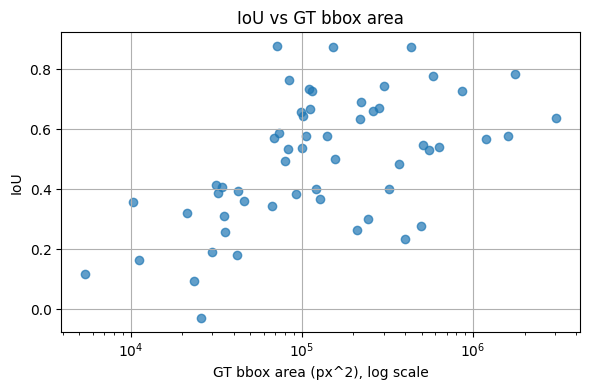

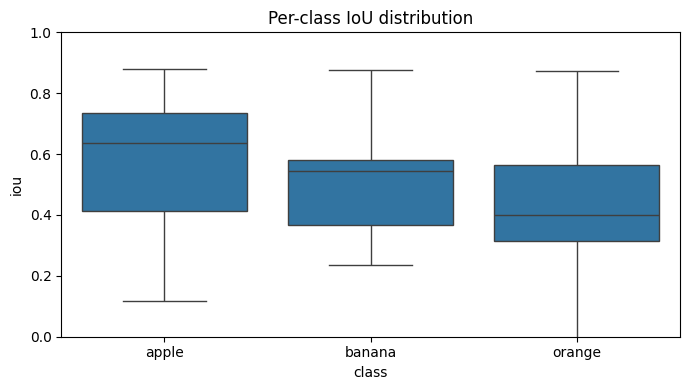

Worst examples (lowest IoU):


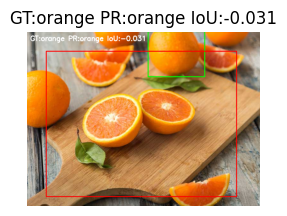

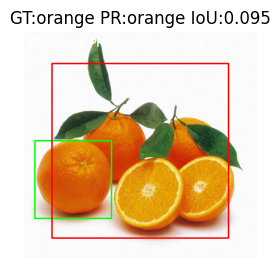

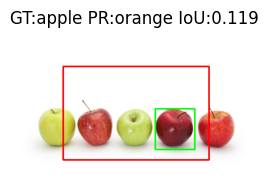

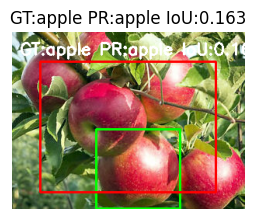

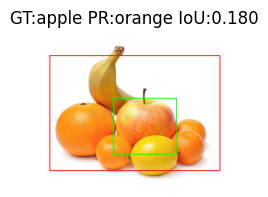

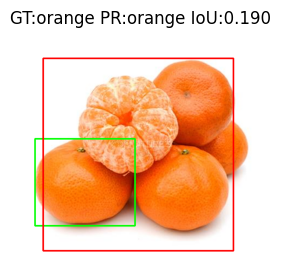

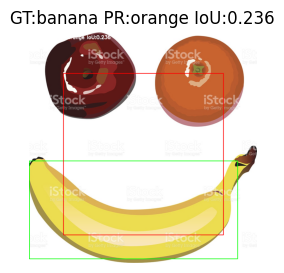

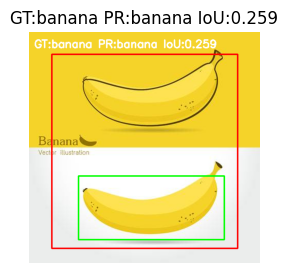

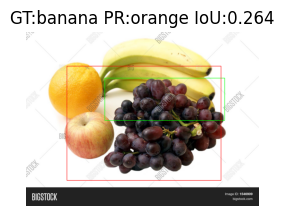

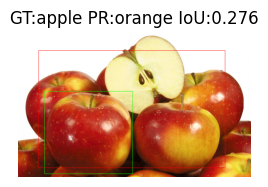

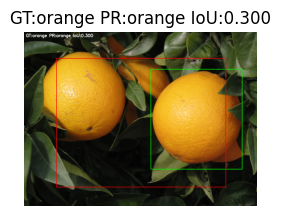

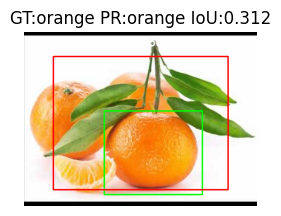

Saved 12 worst-case visualizations to diagnostics


In [19]:
# Diagnostic cell: IoU vs area, per-class IoU, show worst examples
import matplotlib.pyplot as plt
import numpy as np
import cv2, os
from pathlib import Path
from IPython.display import display
import pandas as pd

# Assumes 'results' dict from evaluate_all and val_items, val_ds, model, device, CLASSES exist
res = results  # your evaluate_all output
gt = res['gt']; pred = res['pred']; iou = res['iou']; probs = res['probs']
gt_regs = res['gt_regs']; pred_regs = res['pred_regs']
classes = CLASSES
val_items_list = val_items  # from earlier
diagnostics_dir = Path("diagnostics"); diagnostics_dir.mkdir(exist_ok=True)

# compute gt area in pixels (use original image sizes from val_items)
areas = []
for i, it in enumerate(val_items_list):
    w = max(1, it['xmax'] - it['xmin']); h = max(1, it['ymax'] - it['ymin'])
    areas.append(w * h)
areas = np.array(areas)

# IoU vs area scatter
plt.figure(figsize=(6,4))
plt.scatter(areas, iou, alpha=0.7)
plt.xscale('log')
plt.xlabel('GT bbox area (px^2), log scale'); plt.ylabel('IoU')
plt.title('IoU vs GT bbox area')
plt.grid(True); plt.tight_layout(); plt.show()

# per-class IoU boxplot
import seaborn as sns
df = pd.DataFrame({'class':[classes[c] for c in gt], 'iou': iou, 'area': areas})
plt.figure(figsize=(7,4))
sns.boxplot(x='class', y='iou', data=df)
plt.title('Per-class IoU distribution')
plt.ylim(0,1); plt.tight_layout(); plt.show()

# show worst N examples
N = 12
idxs = np.argsort(iou)[:N]  # lowest IoU
print("Worst examples (lowest IoU):")
for k, idx in enumerate(idxs):
    it = val_items_list[idx]
    img_path = it['img_path']
    img_cv = cv2.imread(img_path)
    if img_cv is None:
        continue
    h, w = img_cv.shape[:2]
    gt_box = gt_regs[idx]   # cx,cy,w,h normalized
    pred_box = pred_regs[idx]
    # helper to convert normalized to pixel coords and crop viz
    def to_xy(box):
        cx,cy,bw,bh = box
        cxp, cyp = int(round(cx * w)), int(round(cy * h))
        wp, hp = int(round(bw * w)), int(round(bh * h))
        xmin = max(0, cxp - wp//2); ymin = max(0, cyp - hp//2)
        xmax = min(w-1, cxp + wp//2); ymax = min(h-1, cyp + hp//2)
        return xmin,ymin,xmax,ymax
    gxy = to_xy(gt_box); pxy = to_xy(pred_box)
    vis = img_cv.copy()
    cv2.rectangle(vis, (gxy[0],gxy[1]), (gxy[2],gxy[3]), (0,255,0), 2)  # GT green
    cv2.rectangle(vis, (pxy[0],pxy[1]), (pxy[2],pxy[3]), (0,0,255), 2)  # Pred red
    lab = f"GT:{classes[gt[idx]]} PR:{classes[pred[idx]]} IoU:{iou[idx]:.3f}"
    cv2.putText(vis, lab, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)
    out_path = diagnostics_dir / f"worst_{k}_{Path(img_path).name}"
    cv2.imwrite(str(out_path), vis)
    # show inline small
    display_image = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(3,3)); plt.imshow(display_image); plt.axis('off'); plt.title(lab); plt.show()

print(f"Saved {min(N, len(idxs))} worst-case visualizations to {diagnostics_dir}")
